In [1]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
from tensorflow import keras
import segmentation_models as sm
from sklearn.model_selection import train_test_split
import tensorflow as tf

from utils.general_utils import *
from utils.data_utils import *
from utils.data_wrappers import *
from utils.submission_utils import *
from utils.run_utils import *

Segmentation Models: using `tf.keras` framework.


In [2]:
# Not recommended to run without GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


Data paths

In [3]:
DATA_DIR = "data"

im_dir = os.path.join(DATA_DIR, 'training/images')
gt_dir = os.path.join(DATA_DIR, 'training/groundtruth')

test_dir = os.path.join(DATA_DIR, 'test')

Load images and plot example image

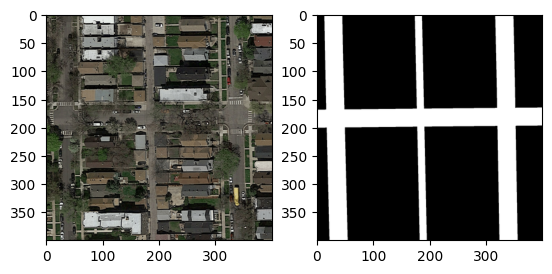

In [4]:
images = imagepath_to_list(im_dir, gt_dir, resize=None)
plot_random(images)

Augment images and show example

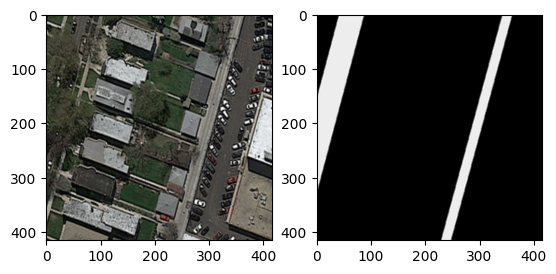

In [5]:
images, augmented= augmentat_images(images, 1)
plot_random(augmented)

Define network parameters

In [6]:
BACKBONE = 'efficientnetb0'
BATCH_SIZE = 64
CLASSES = ['road']
LR = 0.001
EPOCHS = 100

preprocess_input = sm.get_preprocessing(BACKBONE)

n_classes = 1
activation = 'sigmoid'

#create model
model = sm.Unet(BACKBONE, classes=n_classes, activation=activation)

In [7]:
# define optomizer
optim = keras.optimizers.AdamW(learning_rate=LR, weight_decay=1e-4)

# define loss
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.BinaryFocalLoss() 
total_loss = dice_loss + (1 * focal_loss)
bce_loss = sm.losses.BinaryCELoss()

#define metrics
metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compile keras model with defined optimozer, loss and metrics
model.compile(optimizer=optim, loss= total_loss, metrics= metrics)

Create dataloader with preprocessed images

In [8]:
ratio = 0.2 #20% of validation data and 80% of training data
img_train, img_val = train_test_split(images, test_size=ratio, random_state=42)

# Dataset for train images
train_dataset = Dataset(
    img_train,
    classes=CLASSES,
    augmentation=get_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

# Dataset for validation images
valid_dataset = Dataset(
    img_val,
    classes=CLASSES,
    augmentation=get_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloder(valid_dataset, batch_size=32, shuffle=False)


Train model

In [9]:
# define callbacks for learning rate scheduling and best checkpoints saving
#Callbacks used to avoid overfitting

#Save the best model
checkpoint = keras.callbacks.ModelCheckpoint('./best_model.weights.h5', save_weights_only=True, save_best_only=True, mode='min')

#stops the training if validation loss begin to increase -> avoid overfitting
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1)

#reduce the learning rate if validation loss start increase a bit
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

#initialization of the callbacks used
callbacks = [early_stop, checkpoint, reduce_lr]

In [ ]:
# train model
history = model.fit(
    x = train_dataloader,
    epochs=EPOCHS,
    callbacks=callbacks,
    validation_data=valid_dataloader,
)

In [ ]:
plot_metrics(history)

Evaluation on validation

In [ ]:
model.load_weights('best_model.weights.h5')

scores = model.evaluate(valid_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))